In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from io import StringIO
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import openpyxl
import plotly.graph_objects as go
from matplotlib.sankey import Sankey
from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

In [3]:
rain_train = "/kaggle/input/playground-series-s5e3/train.csv"
rain_test = "/kaggle/input/playground-series-s5e3/test.csv"

In [4]:
rain_train_df = pd.read_csv(rain_train)

In [5]:
rain_test_df = pd.read_csv(rain_test)

# Outline

Objective: Create a deep learning model to predict rainfall via machine learning.

How: Model building. 

Evaluation: Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target. 

Prediction Target: rainfall column in rain_train. 

In [6]:
def categorize_wind_dir(degree):
    """
    Categorizes wind direction degrees into cardinal directions.
    Assumes degree is between 0° and 360°.
    """
    if 45 <= degree < 135:
        return 'East'
    elif 135 <= degree < 225:
        return 'South'
    elif 225 <= degree < 315:
        return 'West'
    else:
        return 'North'  # Includes 315–360 and 0–44

In [7]:
wind_source_map = {'North': 0, 'East': 1, 'South': 2, 'West': 3}

In [8]:
for df in [rain_train_df, rain_test_df]:
    df.sort_values('day')
    df['pressure_gradient'] = df['pressure'].diff()
    df['pressure_gradient'] = df['pressure_gradient'].fillna(0)
    df['pressure_dropping'] = (df['pressure_gradient'] < 0).astype(int)
    df['moisture_wind'] = df['winddirection'].apply(lambda x: 1 if 180 <= x <= 270 else 0)
    df['pressure_wind_flow'] = df['pressure_dropping'] * df['moisture_wind'] * df['windspeed']

In [9]:
for df in [rain_train_df, rain_test_df]:
    df['cloud_pressure_temperature'] = df['cloud'] + df['pressure_gradient']
    df['windspeed_humidity'] = df['windspeed'] + df['humidity']
    df['wind'] = df['winddirection'].apply(categorize_wind_dir).map(wind_source_map) + df['windspeed_humidity'] + df['pressure_wind_flow']
    df['sunshine_pressure'] = df['sunshine'] * (df['pressure_gradient'] < 0).astype(int)

                            OLS Regression Results                            
Dep. Variable:               rainfall   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     317.4
Date:                Tue, 25 Mar 2025   Prob (F-statistic):          6.65e-256
Time:                        17:47:44   Log-Likelihood:                -666.24
No. Observations:                2190   AIC:                             1344.
Df Residuals:                    2184   BIC:                             1379.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


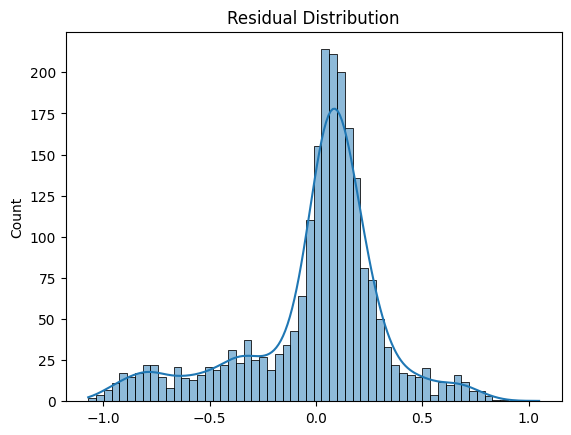


🚀 **Significant Variables at α = 0.05:**
✅ const (p-value: 0.0000)
✅ temparature (p-value: 0.0000)
✅ dewpoint (p-value: 0.0000)
✅ wind (p-value: 0.0000)
✅ cloud_pressure_temperature (p-value: 0.0000)


In [10]:
X = rain_train_df[["temparature","dewpoint", "wind", "sunshine_pressure", "cloud_pressure_temperature"]]
y = rain_train_df["rainfall"]


X = sm.add_constant(X)


model = sm.OLS(y, X).fit()
print(model.summary())


residuals = model.resid
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

p_values = model.pvalues


significant_vars = p_values[p_values < 0.05].index.tolist()


print("\n🚀 **Significant Variables at α = 0.05:**")
for var in significant_vars:
    print(f"✅ {var} (p-value: {p_values[var]:.4f})") 

X = rain_train_df[["temparature", "maxtemp", "mintemp", "dewpoint", "pressure", "windspeed"]]
y = rain_train_df["rainfall"]


X = sm.add_constant(X)


model = sm.OLS(y, X).fit()
print(model.summary())


residuals = model.resid
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

p_values = model.pvalues


significant_vars = p_values[p_values < 0.05].index.tolist()


print("\n🚀 **Significant Variables at α = 0.05:**")
for var in significant_vars:
    print(f"✅ {var} (p-value: {p_values[var]:.4f})") 

# Modelling

In [11]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# ⚠️ 1. Define feature columns BEFORE lda is added
feature_columns = [col for col in rain_train_df.columns if col not in ['rainfall', 'lda']]

# 2. Prepare training data
X = rain_train_df[feature_columns].copy()
X = X.fillna(X.mean())
y = rain_train_df['rainfall']

# 3. Scale
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# 4. Encode target for classification (LDA expects classes)
le = LabelEncoder()
y_encoded = le.fit_transform(y > 0)  # 0 = no rain, 1 = rain

# 5. Fit LDA
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_scaled, y_encoded)

# 6. Add LDA feature
rain_train_df['rainfall'] = X_lda

# ----- TEST SET -----

# 7. Same features for test
X_test = rain_test_df[feature_columns].copy()
X_test = X_test.fillna(X_test.mean())

# 8. Scale using training scaler
X_test_scaled = sc.transform(X_test)

# 9. Apply LDA
X_test_lda = lda.transform(X_test_scaled)

# 10. Add to test set
rain_test_df['rainfall'] = X_test_lda

In [12]:
submission = rain_test_df[['id', 'rainfall']]

# If ordered and un_ordered are required and available in test:
# submission['ordered'] = pastry_test_df['ordered']
# submission['un_ordered'] = pastry_test_df['un_ordered']

# Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved successfully!")

Submission file saved successfully!
